# 1. Import libraries

In [23]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import timedelta
import holidays
from lunardate import LunarDate

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# 2. Load data

In [11]:
# Define url path to CSV
annex1 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex1.csv'
annex2 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex2.csv'
annex3 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex3.csv'
annex4 = 'https://raw.githubusercontent.com/prattapong/Data-Science-Portfolio/main/Projects/Supermaket%20Sales%20Data/data/annex4.csv'

In [12]:
def get_df_from_url(url):
    # Create request response
    response = requests.get(url)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Create a file-like object from the raw content
        csv_content = StringIO(response.text)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_content)

        # Return DataFrame
        return df
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")

df_item = get_df_from_url(annex1)
df_transaction = get_df_from_url(annex2)
df_wholesale = get_df_from_url(annex3)
df_loss = get_df_from_url(annex4)

# 3. Merge and aggregate data

In [13]:
def merge_all_df(df_transaction: pd.DataFrame = df_transaction,
                 df_item: pd.DataFrame = df_item,
                 df_wholesale: pd.DataFrame = df_wholesale,
                 df_loss: pd.DataFrame = df_loss):

    df_merge = df_transaction.merge(df_item,
                                    how = 'left',
                                    on = 'Item Code')
    df_merge = df_merge.merge(df_wholesale,
                            how = 'left',
                            on = ['Date', 'Item Code'])
    df_merge = df_merge.merge(df_loss.drop('Item Name', axis = 1),
                            how = 'left',
                            on = 'Item Code')
    
    return df_merge

df_merge = merge_all_df()

In [14]:
# Create Sales column
df_merge['Sales'] = df_merge['Unit Selling Price (RMB/kg)'] * df_merge['Quantity Sold (kilo)']

# Aggregate as new table
df_agg = df_merge.groupby(['Date', 'Category Code', 'Item Code'], as_index = False)['Sales'].sum()
df_agg.head()

,Date,Category Code,Item Code,Sales
0,2020-07-01,1011010101,102900005115762,41.046
1,2020-07-01,1011010101,102900005115779,335.728
2,2020-07-01,1011010101,102900005115786,68.112
3,2020-07-01,1011010101,102900005115793,68.608
4,2020-07-01,1011010101,102900005115823,114.760


# 4. Feature Engineering

In [15]:
def create_date_feature(df: pd.DataFrame,
                       date_column: str):
    # Convert the 'Date' column to datetime type
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].astype('datetime64[ns]')

    # Extract date components
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday is 0 and Sunday is 6
    df['WeekNumber'] = df['Date'].dt.isocalendar().week
    df['Quarter'] = df['Date'].dt.quarter
    
    return df

def is_holiday(date_value):
    china_holidays = holidays.country_holidays('CN')
    value = 1 if date_value in china_holidays else 0
    return value

def create_days_lag_feature(df: pd.DataFrame, 
                            days: int,
                            grouping_column: list):
    
    # Cast date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].astype('datetime64[ns]')

    # Duplicate DataFrame
    lag_column = grouping_column.copy()
    lag_column.append('Sales')
    df_lag = df[lag_column].copy()

    # Minus number of days
    df_lag['Date'] = df_lag['Date'] + timedelta(days = days)

    # Merge to original DataFrame for new features
    df = df.merge(df_lag,
                  how = 'left',
                  on = grouping_column,
                  suffixes = ['', f'_{days}_daylag'])
    
    return df

In [55]:
def get_chinese_new_year_dates(start_year, end_year):
    chinese_new_year_dates = []

    for year in range(start_year, end_year + 1):
        lunar_date = LunarDate(year, 1, 1)
        cny_date = pd.Timestamp(lunar_date.toSolarDate())

        chinese_new_year_dates.append({'Year': year, 'Chinese New Year Date': cny_date})

    chinese_new_year_df = pd.DataFrame(chinese_new_year_dates)
    chinese_new_year_df['Last Chinese New Year Date'] = chinese_new_year_df['Chinese New Year Date'].shift(1)
    chinese_new_year_df['Date Diff'] = chinese_new_year_df['Chinese New Year Date'] - chinese_new_year_df['Last Chinese New Year Date']
    
    return chinese_new_year_df

def get_chinese_new_year_period(df, days):
    days = 7
    new_years = df['Chinese New Year Date'].unique()
    for new_year in new_years:
        for day in range(-days, days + 1):
            if day != 0:
                df = pd.concat([df, pd.DataFrame({'Chinese New Year Date': [new_year + timedelta(days = day)]})],
                               axis = 0,
                               ignore_index = True)
    return df

df_chinese_new_year = get_chinese_new_year_dates(2021, 2023)
df_chinese_new_year_period = get_chinese_new_year_period(df = df_chinese_new_year, days = 7)

display(df_chinese_new_year)
# display(df_chinese_new_year_period)


,Year,Chinese New Year Date,Last Chinese New Year Date,Date Diff
0,2021,2021-02-12,NaT,NaT
1,2022,2022-02-01,2021-02-12,354 days
2,2023,2023-01-22,2022-02-01,355 days


# 5. Data Preprocessing

## 5.1 Change dtype

In [16]:
def reduce_memory_usage(df: pd.DataFrame,
                        categorical_columns: list = None):
    start_memory = df.memory_usage().sum() / 1024**2

    # Handle categorical columns
    if categorical_columns is not None:
        for col in categorical_columns:
            df[col] = df[col].astype('category')
    else:
        pass
    
    for col in df.columns:
        #  handle numerical features
        if df[col].dtype.name != 'object' and df[col].dtype.name != 'category':
            num_min = df[col].min()
            num_max = df[col].max()
        
            # minimize int dtype bytes
            if 'int' in df[col].dtype.name:
                if num_min > np.iinfo(np.int8).min and num_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype('int8')
                elif num_min > np.iinfo(np.int16).min and num_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype('int16')
                elif num_min > np.iinfo(np.int32).min and num_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype('int32')
                else:
                    df[col] = df[col].astype('int64')
                    
            # minimize float dtype bytes
            elif 'float' in df[col].dtype.name:
                if num_min > np.finfo(np.float16).min and num_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype('float16')
                elif num_min > np.finfo(np.float32).min and num_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype('float32')
                else:
                    df[col] = df[col].astype('float64')
        
        # handle object columns
        else:
            df[col] = df[col].astype('category')

    end_memory = df.memory_usage().sum() / 1024**2
    print('Start Memory: {:.2f} MB\nEnd Memory: {:.2f} MB'.format(start_memory, end_memory))
    return df

In [17]:
categorical_columns = ['Category Code', 'Item Code']
df_agg = reduce_memory_usage(df = df_agg,
                             categorical_columns = categorical_columns)
df_agg.dtypes

Start Memory: 1.42 MB
End Memory: 0.36 MB


Date             category
Category Code    category
Item Code        category
Sales             float16
dtype: object

## 5.2 Split train and test data

In [18]:
def create_split_date(df: pd.DataFrame,
                      date_column: str,
                      train_size: float):
    # Get max and min date of the dataset
    try:
        max_date, min_date = dt.strptime(df[date_column].max(), '%Y-%m-%d'), dt.strptime(df[date_column].min(), '%Y-%m-%d')
    except:
        max_date, min_date = df[date_column].max(), df[date_column].min()

    # Calculate 80% of the date range for splitting
    date_difference = max_date - min_date
    train_split = (min_date + train_size * date_difference).date()
    
    return train_split

def split_train_test_date(df: pd.DataFrame, split_date):
    """
    Split train and test data based on date
    """

    """ Args:
    df: DataFrame to split
    split_date: Date to split between train and test data
    """

    """ Return:
    train, test: pd.DataFrame
    """
    
    # Split train and test
    train = df[df['Date'].dt.date <= split_date]
    train = train.drop('Date', axis = 1)
    test = df[df['Date'].dt.date > split_date]
    test = test.drop('Date', axis = 1)

    print(f'Train size: {train.shape[0]} | {(100 * train.shape[0]/df.shape[0]):.2f}%')
    print(f'Test size: {test.shape[0]} | {(100 * test.shape[0]/df.shape[0]):.2f}%')

    return train, test


# 6. Train and evaluate

## 6.1 Train

In [19]:
def category_train_loop(df: pd.DataFrame, 
                        categories: list, 
                        xgb_model,
                        scaler = None,
                        include_item: bool = False):
    """
    Loop all category and train in each model separatelly
    """

    test_all = pd.DataFrame()
    y_pred_all = []
    for category in categories:
        print(f'Catgory Trainig: {category}')

        # Slice DataFrame to each category
        df_category = df[df['Category Code'] == category]

        # Aggregate
        if include_item == True:
            df_category = df_category.groupby(['Date', 'Item Code', 'Category Code'], as_index = False)['Sales'].sum()
            # Create lag feature
            df_category = create_days_lag_feature(df = df_category,
                                                  days = 365,
                                                  grouping_column = ['Date', 'Item Code', 'Category Code'])
        elif include_item == False:
            df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()
            # Create lag feature
            df_category = create_days_lag_feature(df = df_category,
                                                  days = 365,
                                                  grouping_column = ['Date', 'Category Code'])
            df_category = create_days_lag_feature(df = df_category,
                                                  days = 364,
                                                  grouping_column = ['Date', 'Category Code'])

        # Feature holiday
        df_category['is_holiday'] = df_category['Date'].apply(is_holiday)

        # Create date feature
        df_category = create_date_feature(df = df_category,
                                          date_column = 'Date')

        # Split train and test
        train_split = create_split_date(df = df_category,
                                        date_column = 'Date',
                                        train_size = 0.8)
        train, test = split_train_test_date(df = df_category,
                                            split_date = train_split)

        # Create X and y to train and test
        X_train, y_train = train.drop('Sales', axis = 1), train[['Sales']]
        X_test, y_test = test.drop('Sales', axis = 1), test[['Sales']]

        # Scale data
        if scaler:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        else:
            pass

        ### Training
        print(f'Training...')
        xgb_model.fit(X = X_train,
                      y = y_train,
                      eval_set = [(X_train, y_train), (X_test, y_test)],
                      verbose = 100)
        print('--------------------------------------------\n')

        ### Predict
        y_pred = xgb_model.predict(X_test)

        # Append data to all data
        test_all = pd.concat([test_all, test], axis = 0)
        y_pred_all = np.concatenate((y_pred_all, y_pred))

    return test_all, y_pred_all

def plot_prediction(df_test: pd.DataFrame,
                    y_pred):
    
    # Merge prediction to test data
    df_predict = df_test.reset_index().merge(pd.DataFrame(data = y_pred, columns = ['prediction']),
                                             how = 'left',
                                             left_index = True,
                                             right_index = True)
    df_predict['Date'] = pd.to_datetime(df_predict[['Year', 'Month', 'Day']])

    # Aggregate to Category level
    df_predict_agg = df_predict.groupby(['Date','Category Code'], as_index = False)[['Sales','prediction']].sum()

    # Calculate RMSE in Category level
    rmse = np.sqrt(mean_squared_error(y_true = df_predict_agg['Sales'],
                                        y_pred = df_predict_agg['prediction']))
    print(f'RMSE: {rmse:.2f}')

    # Plot prediction
    plt.figure(figsize = (10,5))
    sns.lineplot(data = df_predict.groupby('Date')['Sales'].sum(), label = 'True label')
    sns.lineplot(data = df_predict.groupby('Date')['prediction'].sum(), label = 'Prediction')
    plt.show()
    

In [20]:
categories = df_agg['Category Code'].unique()
scaler = StandardScaler()
xgb_reg = xgb.XGBRegressor(n_estimators = 5000,
                            eval_metrics = mean_squared_error,
                            enable_categorical = True,
                            early_stopping_rounds = 200,
                            learning_rate = 0.001,
                            max_depth = 5,
                            random_state = 244)

df_test, y_pred = category_train_loop(categories = categories,
                                      df = df_agg,
                                      xgb_model = xgb_reg,
                                      scaler = scaler,
                                      include_item = False)

Catgory Trainig: 1011010101


/tmp/ipykernel_3077/817900277.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()


Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:424.76740	validation_1-rmse:380.34833
[100]	validation_0-rmse:388.47762	validation_1-rmse:356.59790
[200]	validation_0-rmse:355.90510	validation_1-rmse:336.08289
[300]	validation_0-rmse:326.59442	validation_1-rmse:318.22491
[400]	validation_0-rmse:300.20015	validation_1-rmse:302.65854
[500]	validation_0-rmse:276.55005	validation_1-rmse:289.46617
[600]	validation_0-rmse:255.50872	validation_1-rmse:277.67150
[700]	validation_0-rmse:236.59227	validation_1-rmse:267.56172
[800]	validation_0-rmse:219.81824	validation_1-rmse:259.14311
[900]	validation_0-rmse:204.89756	validation_1-rmse:252.31476
[1000]	validation_0-rmse:191.62182	validation_1-rmse:246.90691
[1100]	validation_0-rmse:179.83368	validation_1-rmse:242.56590
[1200]	validation_0-rmse:169.37192	validation_1-rmse:239.44424
[1300]	validation_0-rmse:160.01286	validation_1-rmse:234.36765
[1400]	validation_0-rmse:151.63671	validation_1-rmse:230.13215
[150

/tmp/ipykernel_3077/817900277.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()


Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:156.70277	validation_1-rmse:135.22991
[100]	validation_0-rmse:144.38553	validation_1-rmse:127.78618
[200]	validation_0-rmse:133.32797	validation_1-rmse:121.17299
[300]	validation_0-rmse:123.44801	validation_1-rmse:115.48853
[400]	validation_0-rmse:114.62915	validation_1-rmse:110.54945
[500]	validation_0-rmse:106.77175	validation_1-rmse:106.26845
[600]	validation_0-rmse:99.80877	validation_1-rmse:102.70041
[700]	validation_0-rmse:93.66398	validation_1-rmse:99.70271
[800]	validation_0-rmse:88.23011	validation_1-rmse:97.10625
[900]	validation_0-rmse:83.41585	validation_1-rmse:94.82931
[1000]	validation_0-rmse:79.14487	validation_1-rmse:92.71762
[1100]	validation_0-rmse:75.37959	validation_1-rmse:90.79357
[1200]	validation_0-rmse:72.06733	validation_1-rmse:89.17087
[1300]	validation_0-rmse:69.15727	validation_1-rmse:87.70910
[1400]	validation_0-rmse:66.60359	validation_1-rmse:86.30765
[1500]	validation_0-r

/tmp/ipykernel_3077/817900277.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()


Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:172.70450	validation_1-rmse:139.66750
[100]	validation_0-rmse:161.11374	validation_1-rmse:129.36613
[200]	validation_0-rmse:150.94956	validation_1-rmse:120.62468
[300]	validation_0-rmse:141.95907	validation_1-rmse:113.49300
[400]	validation_0-rmse:133.99385	validation_1-rmse:107.42798
[500]	validation_0-rmse:126.83620	validation_1-rmse:102.92229
[600]	validation_0-rmse:120.44950	validation_1-rmse:99.06977
[700]	validation_0-rmse:114.78985	validation_1-rmse:96.01482
[800]	validation_0-rmse:109.78107	validation_1-rmse:93.65493
[900]	validation_0-rmse:105.30573	validation_1-rmse:91.76155
[1000]	validation_0-rmse:101.29603	validation_1-rmse:90.61511
[1100]	validation_0-rmse:97.78437	validation_1-rmse:90.17224
[1200]	validation_0-rmse:94.74358	validation_1-rmse:90.04111
[1300]	validation_0-rmse:92.17516	validation_1-rmse:90.28668
[1365]	validation_0-rmse:90.62971	validation_1-rmse:90.58572
-----------------

/tmp/ipykernel_3077/817900277.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()


Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:86.39347	validation_1-rmse:80.86906
[100]	validation_0-rmse:80.11836	validation_1-rmse:74.19521
[200]	validation_0-rmse:74.53708	validation_1-rmse:68.54771
[300]	validation_0-rmse:69.57750	validation_1-rmse:63.85625
[400]	validation_0-rmse:65.18009	validation_1-rmse:60.05459
[500]	validation_0-rmse:61.25758	validation_1-rmse:56.79398
[600]	validation_0-rmse:57.78823	validation_1-rmse:54.11768
[700]	validation_0-rmse:54.71732	validation_1-rmse:51.18957
[800]	validation_0-rmse:52.01832	validation_1-rmse:50.01577
[900]	validation_0-rmse:49.56502	validation_1-rmse:49.16245
[1000]	validation_0-rmse:47.32688	validation_1-rmse:48.68501
[1100]	validation_0-rmse:45.27767	validation_1-rmse:48.58363
[1200]	validation_0-rmse:43.44814	validation_1-rmse:48.78168
[1282]	validation_0-rmse:42.09954	validation_1-rmse:49.12103
--------------------------------------------

Catgory Trainig: 1011010504


/tmp/ipykernel_3077/817900277.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()


Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:383.29297	validation_1-rmse:356.90480
[100]	validation_0-rmse:360.18635	validation_1-rmse:332.99585
[200]	validation_0-rmse:340.02813	validation_1-rmse:313.55789
[300]	validation_0-rmse:322.40202	validation_1-rmse:298.01632
[400]	validation_0-rmse:306.72057	validation_1-rmse:285.44434
[500]	validation_0-rmse:291.00843	validation_1-rmse:274.45581
[600]	validation_0-rmse:276.51160	validation_1-rmse:264.90882
[700]	validation_0-rmse:263.61515	validation_1-rmse:257.15737
[800]	validation_0-rmse:252.07929	validation_1-rmse:250.76164
[900]	validation_0-rmse:242.10282	validation_1-rmse:245.81342
[1000]	validation_0-rmse:233.31584	validation_1-rmse:241.85646
[1100]	validation_0-rmse:225.25887	validation_1-rmse:238.80893
[1200]	validation_0-rmse:217.61707	validation_1-rmse:236.38888
[1300]	validation_0-rmse:210.55986	validation_1-rmse:234.64221
[1400]	validation_0-rmse:204.43953	validation_1-rmse:233.38100
[150

/tmp/ipykernel_3077/817900277.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_category = df_category.groupby(['Date', 'Category Code'], as_index = False)['Sales'].sum()


Train size: 5226 | 80.28%
Test size: 1284 | 19.72%
Training...
[0]	validation_0-rmse:261.73973	validation_1-rmse:280.12994
[100]	validation_0-rmse:242.04159	validation_1-rmse:268.97702
[200]	validation_0-rmse:224.45589	validation_1-rmse:259.91615
[300]	validation_0-rmse:208.79375	validation_1-rmse:252.15148
[400]	validation_0-rmse:194.78215	validation_1-rmse:245.26655
[500]	validation_0-rmse:182.16878	validation_1-rmse:238.84436
[600]	validation_0-rmse:170.19902	validation_1-rmse:231.23306
[700]	validation_0-rmse:159.58342	validation_1-rmse:224.95256
[800]	validation_0-rmse:150.13075	validation_1-rmse:219.48122
[900]	validation_0-rmse:141.69644	validation_1-rmse:214.72913
[1000]	validation_0-rmse:133.95685	validation_1-rmse:210.33498
[1100]	validation_0-rmse:126.92895	validation_1-rmse:206.35985
[1200]	validation_0-rmse:120.72872	validation_1-rmse:203.06684
[1300]	validation_0-rmse:115.33393	validation_1-rmse:200.37541
[1400]	validation_0-rmse:110.46803	validation_1-rmse:197.61668
[150

# 7. Results

RMSE: 364.37


/tmp/ipykernel_3077/817900277.py:88: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_predict_agg = df_predict.groupby(['Date','Category Code'], as_index = False)[['Sales','prediction']].sum()


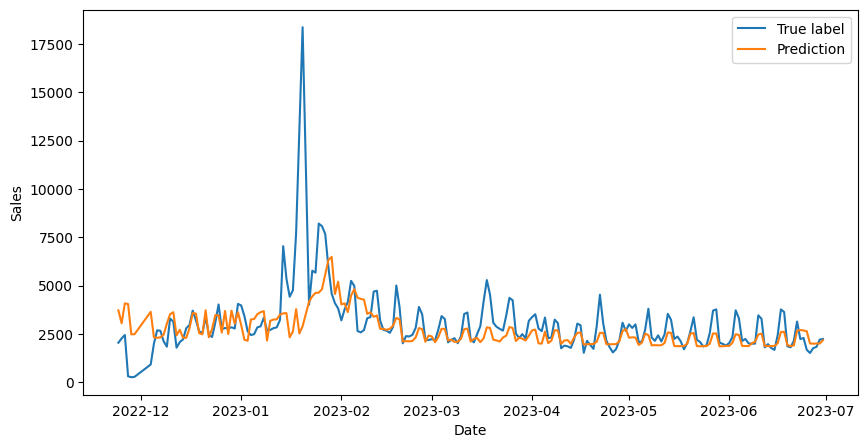

In [21]:
plot_prediction(df_test = df_test,
                y_pred = y_pred)

In [22]:
df_predict = df_test.reset_index().merge(pd.DataFrame(data = y_pred, columns = ['prediction']),
                                             how = 'left',
                                             left_index = True,
                                             right_index = True)
df_predict['Abs Error'] = abs(df_predict['Sales'] - df_predict['prediction'])
df_predict.sort_values(by = 'Abs Error', ascending = False).head()

,index,Category Code,Sales,Sales_365_daylag,Sales_364_daylag,is_holiday,Year,Month,Day,DayOfWeek,WeekNumber,Quarter,prediction,Abs Error
5458,5548,1011010504,6036.382812,657.947266,831.328125,0,2023,1,20,4,3,1,732.385620,5303.997192
5452,5542,1011010504,4398.406250,540.995117,657.947266,0,2023,1,19,3,3,1,732.385620,3666.020630
318,5544,1011010101,3911.250000,573.203125,597.609375,0,2023,1,20,4,3,1,625.118164,3286.131836
6743,5549,1011010801,3731.937500,593.210938,602.474609,0,2023,1,20,4,3,1,600.417603,3131.519897
6737,5543,1011010801,3173.509766,546.207031,593.210938,0,2023,1,19,3,3,1,397.046234,2776.463531
